# Implémentation et test du modèle XGBOOST
---

Dans ce notebook, on va découvrir les différents aspects du modèle XGBOOST. En premier lieu nous allons implémenter le modèle à zéro (from scratch) ensuite en deuxième partie nous allons directement utiliser le modèle depuis l'officielle bibliothèque ([xgboost](https://github.com/dmlc/xgboost)) et effectuer avec différents tests.

## Sommaire
* [Introduction](#introduction)
* [Réalisation des algorithmes](#i-réalisation-des-algorithmes)
    * [Fonction de prédiction](#i1-fonction-de-prédiction)
    * [Fonction du coût](#i2-fonction-du-coût)
        * [Régression](#i21-fonction-du-coût-régression)
        * [Classification](#i22-fonction-du-coût-classification)
    * [Construction des arbres XGBOOST](#i3-constuction-des-arbres-uniques-de-régression-arbres-xgboost)
        * [Fonction du coût de l'arbre](#i31-fonction-de-coût-de-larbre)
        * [Approximation de la fonction du coût de l'arbre](#i32-approximation-de-la-fonction-coût-de-larbre)
        * [Quality Score et Poids des feuilles](#i33-quality-score-et-poids-des-feuilles)
        * [Choix des caractéristiques](#i34-choix-des-caractéristiques)
        * [Regrouper le tout](#i35-regrouper-le-tout)
    * [Regrouper le modèle XGBOOST](#i4-regrouper-le-modèle-xgboost)
* [Test du modèle et comparaison](#ii-test-du-modèle-et-comparaison)
    * [Test du modèle XGBOOST](#ii1-test-du-modèle-xgboost)
    * [Comparaison avec LightGBM et Catboost](#ii2-comparaison-avec-lightgbm-et-catboost)

In [32]:
# Importation des modules nécessaires

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.__version__, pd.__version__

('1.24.3', '2.0.1')

## Introduction

Pour bien débuter, nous posons d'abord les premières notions qu'on va utiliser directement dans les prochaines sections.
Tout au long du notebook, en parlant du dataset donné on note le nombre d'individus $n$ et le nombre de caractéristiques de chaque individu $m$. Ou plus explicitement le dataset ($D$) est donné comme il suit:
$$D = \{(x_i,y_i) \text{ tq } x_i \in R^m, y_i \in R\}$$

## I. Réalisation des algorithmes

Cette partie servira à la compréhension des algorithmes utilisés dans un modèle XGBOOST en les implémentant de zéro pour les deux cas (Régression et Classification). Pour cela nous allons utiliser seulement la bibliothèque **numpy** qui est utile dans les calculs matriciels.

### I.1. Fonction de prédiction

Pour un dataset donné ($D$), la fonction de prédiction du modèle est la somme des $K + 1$ plus simples fonctions de prédiction. Les fonctions de prédiction ($f_k$) avec $k >= 1$ donne les résultats du parcours des arbres de régression construits lors de l'entrainement du modèle. Pour la fonction initiale ($f_0$), ce n'est qu'une valeur constante initiale déterminée au début de l'entraînement. On donne la fonction de prédiction du modèle donc comme il suit:
$$\hat{y_i} = \phi(x_i) = f_0 + \eta \sum\limits_{k = 1}\limits^{K} f_k(x_i)$$
Note: $\eta$ représente le taux d'apprentissage (learning rate)

In [33]:
def pred(X, f0, fs, eta=0.3):
    return f0 + eta * np.sum(np.array([fk(X) for fk in fs]), axis=0)

# Ceci n'est qu'un exemple d'une fonction d'un arbre pour faire fonctionner le test
def f_test(X):
    return np.sum(np.square(X) + X + 4, axis=1)

X = np.array(
    [
        [1, 3],
        [4, 5]
    ]
)

f0 = 3.4

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([16.6, 38.2])
#---------------------------------------------------------------------

pred(X, f0, [f_test, f_test])

array([16.6, 38.2])

### I.2 Fonction du coût

L'étape suivante serait de définir la fonction du coût (loss function) pour évaluer le modèle et le faire converger vers le point optimal. Or on a deux cas: la régression et la classification. Et donc on définira pour chacun des cas sa fonction de coût ensuite leurs dérivées pour pouvoir appliquer le [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) par la suite. 

#### I.2.1 Fonction du coût (Régression)

Pour la régression, nous allons utiliser la somme des erreurs carrées (sum of squares error, SSE). Elle est définie comme il suit
$$SSE = l(y_i,\hat{y_i}) = \frac{1}{2} (y_i - \hat{y_i})^2$$
Note: la fraction $\frac{1}{2}$ est ajoutée juste pour simplifier les calculs (notamment pour la dérivée)

In [34]:
def SSE(Y, Y_pred):
    return (1/2) * np.square(Y - Y_pred)

Y = np.array([1.2, 3.5, 6.7])
Y_pred = np.array([1.0, 4, 7.2])

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([0.02 , 0.125, 0.125])
#---------------------------------------------------------------------

SSE(Y, Y_pred)

array([0.02 , 0.125, 0.125])

Ensuite on calcule la dérivée de cette fonction de coût par rapport aux prédictions réalisées. Cela nous permettra de trouver la prédiction qui minimise la fonction coût. La dérivée est donc donnée comme il suit:
$$\frac{\partial SSE}{\partial \hat{y_i}} = \hat{y_i} - y_i$$
Note: La valeur $y_i - \hat{y_i}$ est appelée le résidu **$r_{ik}$** où $k$ représente le numéro de l'itération. Donc on a:
$$r_{ik} = - \frac{\partial SSE}{\partial \hat{y_i}}$$

In [35]:
def dSSE(Y, Y_pred):
    return Y_pred - Y

Y = np.array([1.2, 3.5, 6.7])
Y_pred = np.array([1.0, 4, 7.2])

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([-0.2,  0.5,  0.5])
#---------------------------------------------------------------------

dSSE(Y, Y_pred)

array([-0.2,  0.5,  0.5])

#### I.2.2 Fonction du coût (Classification)

Pour la classification (dans ce cas binaire), nous allons utiliser l'inverse du log de vraisemblance (negative log-likelihood). Elle est définie comme il suit
$$NLL = l(y_i,p_i) = -\text{ }(\text{ }y_i \log(p_i) + (1-y_i) \log(1-p_i)\text{ })$$
Note: $p_i$ est la probabilité prédite par le modèle. Une valeur proche de 0 signifie que le modèle classe l'individu à la classe négative et une valeur proche de 1 signifie que le modèle classe l'individu à la classe positive.

In [36]:
def NLL(Y, Y_pred):
    return - (Y * np.log(Y_pred) + (1 - Y) * np.log(1 - Y_pred))

Y = np.array([1, 0, 1])
Y_pred = np.array([0.7, 0.2, 0.8])

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([0.35667494, 0.22314355, 0.22314355])
#---------------------------------------------------------------------

NLL(Y, Y_pred)

array([0.35667494, 0.22314355, 0.22314355])

Ensuite on calcule la dérivée de cette fonction de coût par rapport au log de chance de gain (log of odds). Cela nous permettra de trouver la prédiction qui minimise la fonction coût. On rappele que la chance de gain (odds) d'un évènement de propababilité $p$ est définie par:
$$odds = \frac{p}{1 - p}$$
$$\log(odds) = \log(\frac{p}{1 - p})$$
Dériver par rapport au $\log(odds)$ est aussi un choix minutieux pour réduire et faciliter les calculs pour le modèle. Il est permis de faire ce choix car il y a une relation directe entre le $\log(odds)$ et la probabilité $p$. En effet, On peut récupérer la probalité $p$ depuis $\log(odds)$ ainsi:
$$p = \frac{e^{\log(odds)}}{1 + e^{\log(odds)}}$$

In [37]:
def p_to_log_odds(p):
    return np.log(p / (1-p))

def log_odds_to_p(log_odds):
    return np.exp(log_odds) / (1 + np.exp(log_odds))

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (0.708185057924486, 0.67)
#---------------------------------------------------------------------

p_to_log_odds(0.67), log_odds_to_p(0.708185057924486)

(0.708185057924486, 0.67)

Calculons maintenant la dérivée par rapport au $\log(odds)$:
$$\frac{\partial NLL}{\partial \log(odds)} = \frac{\partial}{\partial \log(odds)} -(\text{ }y_i \log(p_i) + (1-y_i) \log(1-p_i)\text{ })$$
$$\frac{\partial NLL}{\partial \log(odds)} = \frac{\partial}{\partial \log(odds)} -y_i \log(p_i) + y_i \log(1-p_i) - \log(1-p_i)$$
$$\frac{\partial NLL}{\partial \log(odds)} = \frac{\partial}{\partial \log(odds)} -y_i (\log(p_i) - \log(1-p_i)) - \log(1-p_i)$$
$$\frac{\partial NLL}{\partial \log(odds)} = \frac{\partial}{\partial \log(odds)} -y_i \log(\frac{p_i}{1-p_i}) - \log(1-p_i)$$
$$\frac{\partial NLL}{\partial \log(odds)} = \frac{\partial}{\partial \log(odds)} -y_i \log(odds) - \log(1-p_i)$$
On a:
$$\log(1-p_i) = \log(1 - \frac{e^{\log(odds)}}{1 + e^{\log(odds)}}) = \log(\frac{1 + e^{\log(odds)}}{1 + e^{\log(odds)}} - \frac{e^{\log(odds)}}{1 + e^{\log(odds)}}) = \log(\frac{1}{1 + e^{\log(odds)}})$$
$$\log(1-p_i) = -\log(1 + e^{\log(odds)})$$
Et donc:
$$\frac{\partial NLL}{\partial \log(odds)} = \frac{\partial}{\partial \log(odds)} -y_i \log(odds) + \log(1 + e^{\log(odds)})$$
$$\frac{\partial NLL}{\partial \log(odds)} = -y_i + \frac{e^{\log(odds)}}{1 + e^{\log(odds)}}$$
$$\frac{\partial NLL}{\partial \log(odds)} = p_i - y_i$$
Note: La valeur $y_i - p_i$ est aussi appelée le résidu $r_{ik}$ où $k$ représente le numéro de l'itération. Donc on a:
$$r_{ik} = - \frac{\partial NLL}{\partial \log(odds)}$$

In [38]:
def dNLL(Y, Y_pred):
    return Y_pred - Y

Y = np.array([1, 0, 1])
Y_pred = np.array([0.7, 0.2, 0.8])

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([-0.3,  0.2, -0.2])
#---------------------------------------------------------------------

dNLL(Y, Y_pred)

array([-0.3,  0.2, -0.2])

### I.3 Constuction des arbres uniques de régression (Arbres XGBOOST)

La fonction de prédiction du modèle XGBOOST dépend des arbres de régression construit lors de l'entrainement. Ces arbres sont des arbres spéciaux appelés des arbres uniques (ou arbres XGBOOST) qui servent à prédir des résidus ($r_{ik}$). En additionnant leurs résultats multipliés par un taux d'apprentissage et ajouté à la prédiction initiale, cela nous donne la prédiction finale du modèle (gradient tree boosting).

#### I.3.1 Fonction de coût de l'arbre

Pendant la construction l'arbre, il faudrait minimiser une certaine fonction de coût (loss function). Son équation est donnée ci-dessous:
$$L^{(k)} = \sum\limits_{i=1}\limits^{n} l(y_i,\hat{y_i}^{(k-1)}+f_k(x_i)) + \Omega(f_k)$$
$$L^{(k)} = \sum\limits_{i=1}\limits^{n} l(y_i,\hat{y_i}^{(k)}) + \Omega(f_k)$$
où
- $y_i$ est la sortie réelle pour l'individu $i$
- $\hat{y_i}^{(k)}$ est la prédiction pour l'individu $i$ faite par le modèle à l'itération **$k$**
- $f_k$ est la fonction qui donne pour tout individu $x_i$ le résultat de l'arbre construit à l'itération $k$
- $l(y_i,\hat{y_i})$ est la fonction de coût (SSE ou NLL dans notre cas)
- $\Omega(f_k)$ est un terme de régulation qui pénalise la complexité du modèle. Il est donné comme il suit:
$$\Omega(f_k) = \gamma T + \frac{1}{2} \lambda \sum\limits_{j=1}\limits^{T} w_j^2$$
où
- $T$ est le nombre de feuilles dans l'arbre
- $w_j$ est le poids de la feuille $j$ dans l'arbre (le calcul de ce poids sera détaillé juste après)
- $\gamma$ est un hyper-paramètre de régularisation, il définit la réduction minimale du coût pour réaliser une partition supplémentaire sur une feuille de l'arbre. Par défaut à 0, une plus grande valeur rend le modèle plus conservatif.
- $\lambda$ est un hyper-paramètre de régularisation L2 sur les poids des feuilles. Par défaut à 1, une plus grande valeur rend le modèle plus conservatif.

In [39]:
# Fonction de coût sans le terme de régularisation
def Lk_sans_reg(Y, Y_pred, loss=SSE):
    return np.sum(loss(Y, Y_pred))

# Terme de régularisation
def reg(W, reg_lambda=1, reg_gamma=0, T=32):
    return reg_gamma * T + (1/2) * reg_lambda * np.sum(np.square(W))

# Fonction de coût complète
def Lk(Y, Y_pred, W, loss=SSE, reg_lambda=1, reg_gamma=0, T=32):
    return Lk_sans_reg(Y, Y_pred, loss) + reg(W, reg_lambda, reg_gamma, T)


Y = np.array([2.2, 8.7])
Y_pred = np.array([1.0, 7.2])

W = np.array([0.2, 0.3, -0.8, 0.7])

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (1.8449999999999989, 1.03, 2.874999999999999)
#---------------------------------------------------------------------

Lk_sans_reg(Y, Y_pred, loss=SSE), reg(W, reg_lambda=1, reg_gamma=0.1, T=4), Lk(Y, Y_pred, W, loss=SSE, reg_lambda=1, reg_gamma=0.1, T=4)

(1.8449999999999989, 1.03, 2.874999999999999)

#### I.3.2 Approximation de la fonction coût de l'arbre

Maintenant que la fonction de coût est bien définie, nous pouvons trouver chaque sortie optimale $f_k(x_i)$ qui minimise le plus la fonction de coût. Celà nécessitera le calcul de dérivée de la fonction coût. Pour optimiser les calculs, le modèle XGBOOST approche le fonction coût par son polynôme de Taylor de second degré:
$$l(y_i,\hat{y_i}^{(k-1)}+f_k(x_i)) \approx l(y_i,\hat{y_i}^{(k-1)}) + \frac{\partial l(y_i,\hat{y_i}^{(k-1)})}{\partial \hat{y_i}^{(k-1)}} f_k(x_i) + \frac{1}{2} \frac{\partial^2 l(y_i,\hat{y_i}^{(k-1)})}{\partial \hat{y_i}^{(k-1)2}} f_k(x_i)^2$$
Et donc
$$L^{(k)} \approx \sum\limits_{i=1}\limits^{n} [\text{ } l(y_i,\hat{y_i}^{(k-1)}) + \frac{\partial l(y_i,\hat{y_i}^{(k-1)})}{\partial \hat{y_i}^{(k-1)}} f_k(x_i) + \frac{1}{2} \frac{\partial^2 l(y_i,\hat{y_i}^{(k-1)})}{\partial \hat{y_i}^{(k-1)2}} f_k(x_i)^2\text{ }] + \Omega(f_k)$$
$$L^{(k)} \approx \sum\limits_{i=1}\limits^{n} [\text{ } l(y_i,\hat{y_i}^{(k-1)}) + g_i f_k(x_i) + \frac{1}{2}h_i f_k(x_i)^2\text{ }] + \Omega(f_k)$$
où
- $g_i$ est la dérivée de la fonction coût par rapport à la prédiction précédente ($\frac{\partial l(y_i,\hat{y_i}^{(k-1)})}{\partial \hat{y_i}^{(k-1)}}$)
- $h_i$ est la seconde dérivée de la fonction coût par rapport à la prédiction précédente ($\frac{\partial^2 l(y_i,\hat{y_i}^{(k-1)})}{\partial \hat{y_i}^{(k-1)2}}$)

#### I.3.3 Quality Score et Poids des feuilles
Définisons plus explicitement la fonction $f_k$, cette fonction nous donne le résultat renvoyé par l'arbre pour un individu avec ses caractéristiques. Ce résultat sera égal au poids d'une des feuilles ($w_j$) de la façon suivante:
$$\hat{y_i}^{(k)} = \hat{y_i}^{(k-1)} + f_k(x_i)$$
$$r_{ik} = y_i - \hat{y_i}^{(k)}$$
$$\text{Si } r_{ik} \in I_j \text{ tel que } I_j \text{ est l'ensemble des résidus se trouvant dans la feuille } j$$
$$\text{Donc } f_k(x_i) = w_j$$
où $w_j$ est le poids de la feuille $j$

On peut considérer maintenant une nouvelle fonction de coût approximative pour l'arbre, où on peut omettre le terme $l(y_i,\hat{y_i}^{(k-1)})$ qui ne représente que le coût de la précédente prédiction qui n'a pas besoin d'être minimisé dans la courante itération. Donc on a maintenant:

$$\tilde{L}^{(k)} = \sum\limits_{i=1}\limits^{n} [\text{ } g_i f_k(x_i) + \frac{1}{2}h_i f_k(x_i)^2\text{ }] + \gamma T + \frac{1}{2} \lambda \sum\limits_{j=1}\limits^{T} w_j^2$$
$$\tilde{L}^{(k)} = \sum\limits_{j=1}\limits^{T} [\text{ } (\sum\limits_{r_{ik} \in I_j}g_i) w_j + \frac{1}{2}(\sum\limits_{r_{ik} \in I_j}h_i + \lambda) w_j^2\text{ }] + \gamma T$$
En résolvant l'équation $\frac{\partial \tilde{L}^{(k)}}{\partial w_j} = 0$ On obtient:
$$w_j^* = -\frac{\sum\limits_{r_{ik} \in I_j}g_i}{\sum\limits_{r_{ik} \in I_j}h_i + \lambda}$$
$$\tilde{L}^{(k)}(w_j^*) = -\frac{1}{2} \sum\limits_{j=1}\limits^{T} \frac{(\sum\limits_{r_{ik} \in I_j}g_i)^2}{\sum\limits_{r_{ik} \in I_j}h_i + \lambda} + \gamma T$$
$$Q_j = \frac{1}{2} \frac{(\sum\limits_{r_{ik} \in I_j}g_i)^2}{\sum\limits_{r_{ik} \in I_j}h_i + \lambda} - \gamma$$
où
- $w_j^*$ est le poids optimal de la feuille
- $\tilde{L}^{(k)}(w_j^*)$ est le coût minimal pour l'arbre
- $Q_j$ est appelée score de qualité ou similarité (Quality or Similarity Score). Puisque elle est inversement proportionelle au coût, le but est de la maximiser.
- Remarque: le coût de l'arbre n'est que la somme des opposés des scores de qualité. C'est à dire: $\tilde{L}^{(k)}(w_j^*) = \sum\limits_{j=1}\limits^{T} - Q_j$

In [40]:
# calcule le score de qualité (similiraté)
def calculer_score(gs:np.ndarray, hs:np.ndarray, reg_lambda=1, reg_gamma=0):
    if gs.size > 0 and hs.size > 0:
        return ((1/2) * (np.sum(gs))**2 / (np.sum(hs) + reg_lambda)) - reg_gamma
    else:
        return 0

# On a maintenant toutes les informations pour créer un noeud de l'arbre
# On définit une classe abstraite pour représenter un noeud en général
# En réalité, cette classe représentera aussi toutes les feuilles (des noeuds qui ne sont ni NoeudCat ni NoeudNum)
class Noeud:

    nbr = 0
    indent = '\t'

    def __init__(self, profondeur:int, num:int=None, val=None, pere=None, estGauche=True):
        self.num = num # le numéro du caractéristique de division dans X
        self.qs = 0 # le quality score pour le noeud
        self.pr = profondeur # la profondeur du noeud
        self.val = val # valeur du noeud
        self.pere = pere # père du noeud
        self.estGauche = estGauche # si le noeud est un fils gauche
        self.fils = {} # les fils du noeud
        self.indices = np.array([]) # indices (i) des individus se classant dans le noeud
        self.res = np.array([]) # les résidus trouvés dans le noeud (applicable que pour les feuilles)
        self.gs = np.array([]) # les dérivés gi de premier ordre du noeud (applicable que pour les feuilles)
        self.hs = np.array([]) # les dérivés hi de second ordre du noeud (applicable que pour les feuilles)
        self.w = 0 # poids du noeud (applicable que pour les feuilles)

    def ajuster(self, indices:np.ndarray, gs:np.ndarray, hs:np.ndarray, reg_lambda=1, reg_gamma=0):
        self.gs = gs
        self.hs = hs
        self.res = - gs
        self.indices = indices
        self.calculer_poids(reg_lambda)
        self.qs = calculer_score(gs, hs, reg_lambda, reg_gamma)
    
    def copier(self, other):
        self.gs = other.gs
        self.hs = other.hs
        self.res = other.res
        self.indices = other.indices
        self.w = other.w
        self.qs = other.qs
        self.pere = other.pere
        self.estGauche = other.estGauche
        self.fils = other.fils

    # Cette fonction sert à transformer le noeud à un string
    def __str__(self):
        tmp_indent = Noeud.indent * self.pr # indentation : esthetique
        
        # Un noeud simple (non dérivé) n'affiche que son poids
        return tmp_indent + f'W = {self.w}\n'

    # predire un échantillon
    def predire(self, x: list):
        # Un noeud simple (non dérivé) ne retourne que son poids
        return self.w

    # générer un code pour graphviz
    def graphviz(self):
        nid = 'N' + str(Noeud.nbr)
        Noeud.nbr += 1
        
        # Un noeud simple (non dérivé) n'affiche que son poids et son score
        res = nid + '[label="W = ' + str(self.w) + '\n'
        res += 'QS = ' + str(self.qs) + '\n'
        res += 'Inds = '+ str(self.indices) + '\n'
        res += 'gs = '+ str(self.gs) + '\n'
        res += 'hs = '+ str(self.hs) + '\n'
        res += '" shape=ellipse];\n'
        return nid, res

    # calcule le poids d'un noeud
    def calculer_poids(self, reg_lambda=1):
        if self.gs.size > 0 and self.hs.size > 0:
            self.w = - (np.sum(self.gs)) / (np.sum(self.hs) + reg_lambda)
        else:
            self.w = 0

# On définit un noeud qu'on appelle NoeudCat pour gérer les données qualitatives, cette classe héritera de la classe Noeud
class NoeudCat(Noeud):
    # Cette fonction sert à transformer le noeud à un string
    def __str__(self):
        tmp_indent = Noeud.indent * self.pr # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.fils)==0):
            return tmp_indent + f'W = {self.w}\n'
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        res = tmp_indent + 'Si X[' + str(self.num) + '] est "' + str(self.val) 
        res += '" Alors\n' + str(self.fils['g'])
        res += tmp_indent + 'Sinon\n' + str(self.fils['d'])
        return res

    # predire un échantillon
    def predire(self, x: list[str]):
        # Si le noeud est final, il rend son poids
        if (len(self.fils)==0):
            return self.w
        
        # sinon
        if x[self.num] == self.val:
            return self.fils['g'].predire(x)
        return self.fils['d'].predire(x)

    # générer un code pour graphviz
    def graphviz(self):
        nid = 'N' + str(Noeud.nbr)
        Noeud.nbr += 1
        
        # Si le noeud est final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + str(self.w) + '" shape=ellipse];\n'
        
        # Sinon, 
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        prefix = '] = '
        res  = nid + '[label="X[' + str(self.num) + prefix + str(self.val) + '\\n'
        res += 'QS = ' + str(self.qs) + '"];\n'
        vid_G, code_G = self.fils['g'].graphviz()
        vid_D, code_D = self.fils['d'].graphviz()
        
        res += code_G + code_D
        res += nid + ' -> ' + vid_G + ' [label="Vrai"];\n'
        res += nid + ' -> ' + vid_D + ' [label="Faux"];\n'
        return nid, res
    
# On définit un noeud qu'on appelle NoeudNum pour gérer les données quantitatives, cette classe héritera de la classe Noeud
class NoeudNum(Noeud):
    # Cette fonction sert à transformer le noeud à un string
    def __str__(self):

        tmp_indent = self.indent * self.pr # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.fils)==0):
            return tmp_indent + f'W = {self.w}\n'
         
        prefix = ' <= '
        suffix = ''
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS SINON
        res  = ''
        res += tmp_indent + 'Si X[' + str(self.num) + ']' + prefix + str(self.val) + suffix 
        res += ' Alors\n' + str(self.fils['g'])
        res += tmp_indent + 'Sinon\n' + str(self.fils['d'])
        return res

    # predire un échantillon
    def predire(self, x: list):
        # Si le noeud est final, il rend son poids
        if (len(self.fils)==0):
            return self.w
        
        # sinon
        if x[self.num] <= self.val:
            return self.fils['g'].predire(x)
        return self.fils['d'].predire(x)

    # générer un code pour graphviz
    def graphviz(self):
        nid = 'N' + str(Noeud.nbr)
        Noeud.nbr += 1
        
        # Si le noeud est final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + str(self.w) + '" shape=ellipse];\n'
        
        # Sinon, 
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        prefix = '] <= '
        res = nid + '[label="X[' + str(self.num) + prefix + str(self.val) + '\\n'
        res += 'QS = ' + str(self.qs) + '"];\n'
        vid_G, code_G = self.fils['g'].graphviz()
        vid_D, code_D = self.fils['d'].graphviz()
        
        res += code_G + code_D
        res += nid + ' -> ' + vid_G + ' [label="Vrai"];\n'
        res += nid + ' -> ' + vid_D + ' [label="Faux"];\n'
        return nid, res
    
gs = np.array([10.7, -2.5, 4.3, 15.1])
hs = np.array([0.25, 0.1, 0.3, 0.4])

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# 185.79512195121956
#---------------------------------------------------------------------

calculer_score(gs, hs)

185.79512195121956

Puisque nous allons avoir besoin des dérivés de second ordre (hessiennes), nous les calculons pour les deux fonctions de coût (loss functions) précédemment définies (SSE et NLL).
$$\frac{\partial SSE}{\partial \hat{y_i}} = \hat{y_i} - y_i \Longleftrightarrow \frac{\partial^2 SSE}{\partial \hat{y_i}^2} = 1$$
$$\frac{\partial NLL}{\partial \log(odds)} = -y_i + \frac{e^{\log(odds)}}{1 + e^{\log(odds)}} \Longleftrightarrow \frac{\partial^2 NLL}{\partial \log(odds)^2} = \frac{e^{\log(odds)}}{(1 + e^{\log(odds)})^2}$$
$$\Longleftrightarrow \frac{\partial^2 NLL}{\partial \log(odds)^2} = \frac{e^{\log(odds)}}{(1 + e^{\log(odds)})} \frac{1}{(1 + e^{\log(odds)})} = p_i (1-p_i)$$

In [41]:
def hSSE(Y, Y_pred):
    return np.ones(Y_pred.size)

def hNLL(Y, Y_pred):
    return Y_pred * (1-Y_pred)

Y = np.array([1, 0, 1])
Y_pred = np.array([0.7, 0.2, 0.8])

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([1., 1., 1.]), array([0.21, 0.16, 0.16]))
#---------------------------------------------------------------------

hSSE(Y, Y_pred), hNLL(Y, Y_pred)

(array([1., 1., 1.]), array([0.21, 0.16, 0.16]))

#### I.3.4 Choix des caractéristiques
Pour choisir les caractéristiques ou les valeurs à comparer aux caractéristiques (quantiles) pour chaque noeud on calcule le gain en score. Ce gain est calculé comme il suit:
$$gain = Q_g + Q_d - Q_r$$
où
- $Q_r$ représente le score de qualité au noeud courant
- $Q_g$ représente le score de qualité au fils gauche
- $Q_d$ représente le score de qualité au fils droit

De plus, pour déterminer l'ensemble des quantiles pour les caractéristiques quantitatives (supposant que c'est l'utilisateur qui choisit le nombre des quantiles), XGBOOST utilise le principe des quantiles pondérés (Weighted Quantile Sketch), qui consiste à affecter à chaque individu un poids ($w_i$). Les intervalles créés par les quantiles choisis ont la même somme des poids de leurs individus.
$$w_i^{(k)} = \begin{cases}
1 & \text{pour la régression}\\
p_i^{(k-1)} (1-p_i^{(k-1)}) & \text{pour la classification}
\end{cases}
$$
$$\text{où } p_i^{(k-1)} \text{ représente la probabilité pour l'individu }i\text{ à l'itération précédente}$$

In [42]:
# fonction qui divise une colonne quantitative en utilisant le Weighted Quantile Sketch. Le résultat serait une liste de quantiles.
# Remarque: la colonne Xj doit être ordonnée et W (le vecteur de poids des individus doit suivre le même ordre)
# n: représente le nombre quantile à générer (dans la littérature XGBOOST génère par défaut 33 quantiles)
def diviser_quantiles(Xj:np.ndarray, W:np.ndarray, n=33):
    n = min(W.size - 1, n) # Pour s'assurer qu'on ne demande pas un nombre de quantiles impossible
    ind_sorted = Xj.argsort() # récupérer les indices ordonnés dans l'ordre croissant
    r = [] # Résultats
    d = np.sum(W)/(n+1) # Critère de division
    W_cum = np.cumsum(W[ind_sorted])
    mask = None

    i = 0
    cpt = 0
    while i < n and cpt <= n:
        if cpt == n: # dans le cas où la dernière est exactement à la limite on la prend dans le dernier intervalle
            mask = (W_cum >= cpt*d) & (W_cum <= (cpt+1)*d)
        else:
            mask = (W_cum >= cpt*d) & (W_cum < (cpt+1)*d)
        
        if len(Xj[ind_sorted][mask]) > 0:
            i += 1
            r.append(np.max(Xj[ind_sorted][mask]))

        cpt += 1
            
    return np.array(r)

Xj = np.array([3.2, 1.2, 1.6, 4.5, 5.5, 5.6, 7])
W = np.array([0.2, 0.2, 0.3, 0.5, 0.5, 0.1, 0.3])
#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array([1.2, 3.2, 4.5, 7. ])
#---------------------------------------------------------------------

diviser_quantiles(Xj, W, n=4)

array([1.2, 3.2, 4.5, 7. ])

#### I.3.5 Regrouper le tout

In [43]:
class XGBTree:
    # Initialiser l'arbre
    def __init__(self, prev_pred, cls=False, max_depth=6, reg_lambda=1, reg_gamma=0):
        self.cls = cls # est à Vrai, si c'est une classification, 0 sinon (régression)
        if cls:
            self.loss = NLL # fonction du coût
            self.dloss = dNLL # dérivée de la fonction du coût
            self.hloss = hNLL # seconde dérivée de la fonction du coût
            self.prev_pred = p_to_log_odds(prev_pred) # log(odds)
        else:
            self.loss = SSE # fonction du coût
            self.dloss = dSSE # dérivée de la fonction du coût
            self.hloss = hSSE # seconde dérivée de la fonction du coût
            self.prev_pred = prev_pred # précédente prédiction

        self.reg_lambda = reg_lambda # hyper-paramètre de régularisation
        self.reg_gamma = reg_gamma # hyper-paramètre de régularisation
        self.W_feuilles = [] # poids des feuilles, cet attribut sera utile pour calculer le coût régularisé du modèle
        self.max_depth = max_depth # hyper-paramètre qui limite la profondeur maximale de l'arbre
        

    # Pour un noeud donné et une caractéristique qualitative donnée choisir la modalité qui minimise le mieux le coût
    def choisir_valeur_cat(self, Xj:np.ndarray, Y:np.ndarray, Y_pred: np.ndarray, qs_past: float):
        s = np.unique(Xj)
        max_gain = -1
        gs_g_result = np.array([])
        hs_g_result = np.array([])
        gs_d_result = np.array([])
        hs_d_result = np.array([])
        mask_result = np.array([])
        val = None
        for sk in s:
            mask = Xj == sk
            gs_g = self.dloss(Y[mask], Y_pred[mask])
            hs_g = self.hloss(Y[mask], Y_pred[mask])
            gs_d = self.dloss(Y[~mask], Y_pred[~mask])
            hs_d = self.hloss(Y[~mask], Y_pred[~mask])
            qs_g = calculer_score(gs_g, hs_g, self.reg_lambda, self.reg_gamma)
            qs_d = calculer_score(gs_d, hs_d, self.reg_lambda, self.reg_gamma)
            gain_qs = qs_g + qs_d - qs_past
            if gain_qs > max_gain:
                gs_g_result = gs_g
                hs_g_result = hs_g
                gs_d_result = gs_d
                hs_d_result = hs_d
                mask_result = mask
                max_gain = gain_qs
                val = sk

        return gs_g_result, hs_g_result, gs_d_result, hs_d_result, mask_result, max_gain, val
    
    # Pour un noeud donné et une caractéristique quantitative donnée choisir le quantile qui minimise le mieux le coût
    def choisir_valeur_num(self, Xj:np.ndarray, Y:np.ndarray, Y_pred: np.ndarray, qs_past: float, W:np.ndarray, n=33):
        s = diviser_quantiles(Xj, W, n)
        max_gain = -1
        gs_g_result = np.array([])
        hs_g_result = np.array([])
        gs_d_result = np.array([])
        hs_d_result = np.array([])
        mask_result = np.array([])
        val = None
        for sk in s:
            mask = Xj <= sk
            gs_g = self.dloss(Y[mask], Y_pred[mask])
            hs_g = self.hloss(Y[mask], Y_pred[mask])
            gs_d = self.dloss(Y[~mask], Y_pred[~mask])
            hs_d = self.hloss(Y[~mask], Y_pred[~mask])
            qs_g = calculer_score(gs_g, hs_g, self.reg_lambda, self.reg_gamma)
            qs_d = calculer_score(gs_d, hs_d, self.reg_lambda, self.reg_gamma)
            gain_qs = qs_g + qs_d - qs_past
            if gain_qs > max_gain:
                gs_g_result = gs_g
                hs_g_result = hs_g
                gs_d_result = gs_d
                hs_d_result = hs_d
                mask_result = mask
                max_gain = gain_qs
                val = sk

        return gs_g_result, hs_g_result, gs_d_result, hs_d_result, mask_result, max_gain, val
    
    # Pour un noeud donné la caractéristique qui minimise le mieux le coût
    def choisir_meilleur_noeud(self, r:Noeud, X:pd.DataFrame, Y:np.ndarray, Y_pred:np.ndarray, W:np.ndarray, n=33):
        max_gain = -1
        categorical = False
        gs_g_result = np.array([])
        hs_g_result = np.array([])
        gs_d_result = np.array([])
        hs_d_result = np.array([])
        mask_result = np.array([])
        max_j = 0
        max_val = None
        for j in range(X.shape[1]):
            if np.issubdtype(X.iloc[:,j].dtype, np.number):
                gs_g, hs_g, gs_d, hs_d, mask, gain_qs, val = self.choisir_valeur_num(X.iloc[:,j].values, Y, Y_pred, r.qs, W, n)
                if gain_qs > max_gain:
                    gs_g_result = gs_g
                    hs_g_result = hs_g
                    gs_d_result = gs_d
                    hs_d_result = hs_d
                    max_gain = gain_qs
                    mask_result = mask
                    max_j = j
                    max_val = val
                    categorical = False
            else:
                gs_g, hs_g, gs_d, hs_d, mask, gain_qs, val = self.choisir_valeur_cat(X.iloc[:,j].values, Y, Y_pred, r.qs)
                if gain_qs > max_gain:
                    gs_g_result = gs_g
                    hs_g_result = hs_g
                    gs_d_result = gs_d
                    hs_d_result = hs_d
                    max_gain = gain_qs
                    mask_result = mask
                    max_j = j
                    max_val = val
                    categorical = True

        # Si le masque est homogène, c'est une feuille
        if np.all(mask_result) or np.all(~mask_result):
            self.T += 1 # On incrémente le nombre de feuilles
            self.W_feuilles.append(r.w) # On sauvegarde son poids
            return r
        
        # Si le gain est inférieur à gamma, ne pas diviser (pruning), c'est une feuille
        if max_gain < self.reg_gamma:
            self.T += 1 # On incrémente le nombre de feuilles
            self.W_feuilles.append(r.w) # On sauvegarde son poids
            return r

        # Créer le noeud de décision
        noeud: Noeud = None
        if categorical:
            noeud = NoeudCat(profondeur=r.pr, num=max_j, val=max_val)
        else:
            noeud = NoeudNum(profondeur=r.pr, num=max_j, val=max_val)
        noeud.copier(r)
        
        # Création du noeud gauche
        noeud_g = Noeud(profondeur=r.pr+1, pere=noeud, estGauche=True)
        noeud_g.ajuster(r.indices[mask_result], gs_g_result, hs_g_result, self.reg_lambda, self.reg_gamma)

        # Création du noeud droit
        noeud_d = Noeud(profondeur=r.pr+1, pere=noeud, estGauche=False)
        noeud_d.ajuster(r.indices[~mask_result], gs_d_result, hs_d_result, self.reg_lambda, self.reg_gamma)

        # Lier les noeuds
        noeud.fils = {
            'g': noeud_g,
            'd': noeud_d
        }

        return noeud

    # Fonction générale d'entraînement
    def entrainer(self, X:pd.DataFrame, Y:np.ndarray, X_noms:list[str] = [], Y_nom:str = '', n:int=33):
        self.W = np.ones(X.shape[0]) # Initialiser les poids des individus à 1
        self.T = 0 # Nombre de feuilles
        
        # Créer le premier noeud de l'arbre
        initial_pred = self.prev_pred
        if self.cls:
            initial_pred = log_odds_to_p(self.prev_pred)

        self.arbre = Noeud(profondeur=0)
        self.arbre.ajuster(indices=np.arange(X.shape[0]),gs=self.dloss(Y, initial_pred), hs=self.hloss(Y, initial_pred), 
                           reg_lambda=self.reg_lambda, reg_gamma=self.reg_gamma)
        
        # ======= Entrainer l'arbre depuis le premier noeud ==========================

        noeud_a_traiter = [self.arbre] # File de noeud à traiter
        # Parcourir les noeud en utilisant un algorithme similaire au BFS (Breath First Search)
        # Les noeud sont développés en mode dit level-wise
        while len(noeud_a_traiter) > 0:
            r = noeud_a_traiter[0] # Noeud courant
            if r.res.size <= 1: # S'arrêter s'il n'y a qu'un résidu dans le noeud (c'est une feuille)
                self.T += 1 # On incrémente le nombre de feuilles
                self.W_feuilles.append(r.w) # On sauvegarde son poids
                noeud_a_traiter.pop(0) # Défiler le noeud courant
            else:
                Y_pred = self.prev_pred[r.indices] + np.array([r.predire(X.iloc[r.indices[i],:].values) for i in range(len(r.indices))])
                if self.cls:
                    Y_pred = log_odds_to_p(Y_pred) # Si on entraine une classification, transformer les log(odds) en probabilité pour les prédiction
                    self.W[r.indices] = Y_pred * (1-Y_pred) # Mettre à jour les poids des individus si c'est une classification

                noeud = self.choisir_meilleur_noeud(r, X.iloc[r.indices], Y[r.indices], Y_pred, self.W[r.indices], n) # Choisir la partition qui maximise le quality score
                
                # Mettre à jour le noeud dans l'arbre
                if r.pere == None: # Si le noeud n'a pas de père c'est la racine de l'arbre
                    self.arbre = noeud
                else:
                    if r.estGauche:
                        r.pere.fils['g'] = noeud
                    else:
                        r.pere.fils['d'] = noeud
                
                noeud_a_traiter.pop(0) # Défiler le noeud courant

                # Si le noeud n'est pas une feuille et on est pas arrivé encore à la profondeur maximale
                if len(noeud.fils) > 0 and noeud.pr + 1 < self.max_depth:
                    noeud_a_traiter.append(noeud.fils['g']) # Enfiler le fils gauche
                    noeud_a_traiter.append(noeud.fils['d']) # Enfiler le fils droit

        # ==================== Fin de l'entrainement ==========================================
                    
        # Sauvegarder une représentation textuelle de l'arbre
        code = str(self.arbre)
        if len(Y_nom) > 0: 
            code = code.replace('Y', Y_nom)
        for i in range(len(X_noms)): 
            code = code.replace('X[' + str(i) + ']', X_noms[i])
        self.code   = code
        self.X_noms = X_noms

    # Fonction de prédiction de l'arbre (fk)
    def predire(self, X:pd.DataFrame):
        predictions = []
        for i in range(X.shape[0]): 
            predictions.append(self.arbre.predire(X.iloc[i, :].values))
        return np.array(predictions)
    
    # Fonction pour visualiser l'arbre sur GraphViz
    def graphviz(self): 
        nid, code = self.arbre.graphviz()
        res  = 'digraph Tree {\n'
        res += 'node [shape=box] ;'
        for i in range(len(self.X_noms)): 
            code = code.replace('X[' + str(i) + ']', self.X_noms[i])
        res += code
        res += '}'
        return res
        

In [44]:
# Le dataset "jouer".

# temps, temperature, humidite, vent
X_jouer = pd.DataFrame([
    ['ensoleile', 35.1 , 'haute'  , 'non'],
    ['ensoleile', 34.7 , 'haute'  , 'oui'],
    ['nuageux'  , 33.2 , 'haute'  , 'non'],
    ['pluvieux' , 24.2  , 'haute'  , 'non'],
    ['pluvieux' , 20.2, 'normale', 'non'],
    ['pluvieux' , 18.3, 'normale', 'oui'],
    ['nuageux'  , 19.4, 'normale', 'oui'],
    ['ensoleile', 23.6  , 'haute'  , 'non'],
    ['ensoleile', 17.7, 'normale', 'non'],
    ['pluvieux' , 25.6  , 'normale', 'non'],
    ['ensoleile', 23.3  , 'normale', 'oui'],
    ['nuageux'  , 22.5  , 'haute'  , 'oui'],
    ['nuageux'  , 34.4 , 'normale', 'non'],
    ['pluvieux' , 21.5  , 'haute'  , 'oui']
])

Y_jouer = np.array([0, 0, 1, 1, 1, 0, 1, 
                    0, 1, 1, 1, 1, 1, 0])

prev_pred = np.repeat(np.mean(Y_jouer), Y_jouer.size)
tree = XGBTree(prev_pred, cls=True)
tree.entrainer(X_jouer, Y_jouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer", n=4)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# Si humidite est "haute" Alors
# 	Si temps est "ensoleile" Alors
# 		W = -0.8624903265431408
# 	Sinon
# 		Si temperature <= 21.5 Alors
# 			W = -0.6280343548612316
# 		Sinon
# 			W = 0.4846766221832071
# Sinon
# 	Si temperature <= 18.3 Alors
# 		Si temps est "ensoleile" Alors
# 			W = 0.36019312966087014
# 		Sinon
# 			W = -0.44145432310328875
# 	Sinon
# 		W = 0.6242637766020209

# L'arbre a 6 feuilles
#---------------------------------------------------------------------

print(tree.code)
print("L'arbre a", tree.T, "feuilles")

Si humidite est "haute" Alors
	Si temps est "ensoleile" Alors
		W = -0.8624903265431408
	Sinon
		Si temperature <= 21.5 Alors
			W = -0.6280343548612316
		Sinon
			W = 0.4846766221832071
Sinon
	Si temperature <= 18.3 Alors
		Si temps est "ensoleile" Alors
			W = 0.36019312966087014
		Sinon
			W = -0.44145432310328875
	Sinon
		W = 0.6242637766020209

L'arbre a 6 feuilles


In [45]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


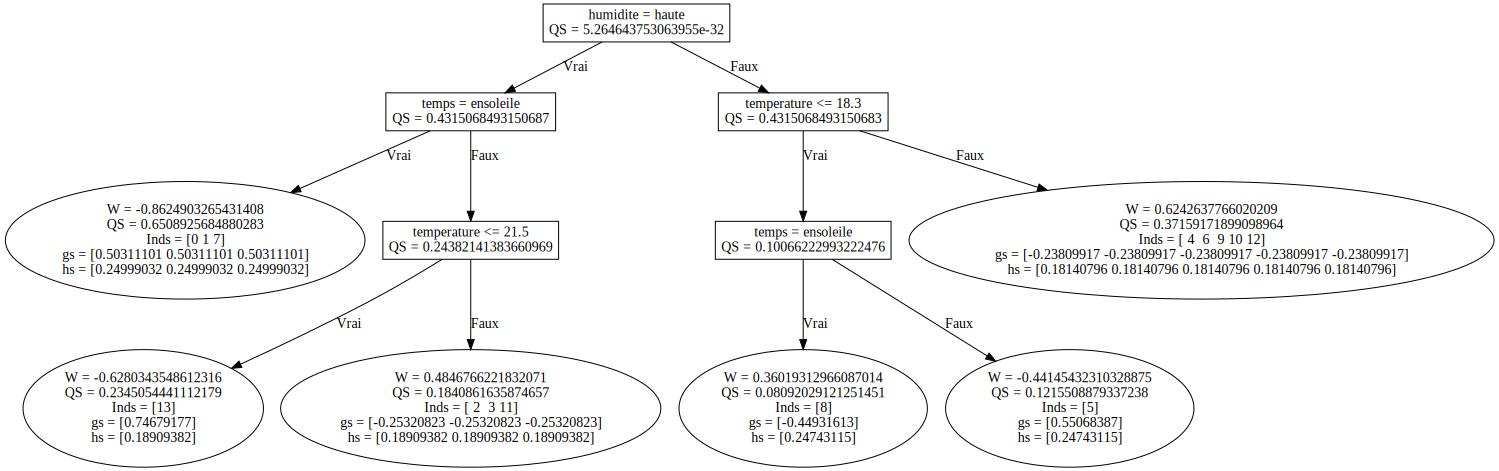

In [46]:
# Visualisation de l'arbre en graphe
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph = Source(tree.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('Il faut installer graphviz')

### I.4 Regrouper le modèle XGBOOST
Maintenant qu'on a des arbres XGBOOST fonctionnels, on peut regrouper tout dans une classe qui représentera le modèle.

In [47]:
class XGBOOST:
    def __init__(self, cls=False, learning_rate=0.3, M=100, max_depth=6, reg_lambda=1, reg_gamma=0, n=33, proba=False, seuil=0.5):
        self.cls = cls
        self.learning_rate = learning_rate # taux d'apprentissage
        self.M = M # nombre d'itérations
        self.reg_lambda = reg_lambda # paramètre de régularisation (lambda)
        self.reg_gamma = reg_gamma # paramètre de régularisation (gamma)
        self.fks = [] # Les fonctions de prédictions des arbres
        self.trees = [] # Les arbres xgboost
        self.n = n # nombre de quantiles à extraire pendant le Weighted Quantile Sketch pour les données quantitative
        self.couts = [] # coûts enregistrés à chaque itération
        self.proba = proba # si vrai et le modèle est en mode classification, le modèle renvoie des probabilité sinon il renvoie des classes 
        self.seuil = seuil # seuil pour la classification (< seuil => 0, >= seuil => 1)
        self.max_depth = max_depth # hyper-paramètre qui limite la profondeur maximale de l'arbre

    # Fonction globale d'entrainement
    def entrainer(self, X:pd.DataFrame, Y:np.ndarray, X_noms:list[str]=[], Y_nom:str=''):
        self.initial_pred = np.repeat(np.mean(Y), Y.size) # Commencer par une prédiction naïve (la moyenne)
        tmp_X_noms = X_noms
        if len(tmp_X_noms) == 0:
            tmp_X_noms = X.columns.values # Si les noms des colonnes ne sont pas donnés prendre ceux de la Dataframe

        courante_pred = self.initial_pred
        # Entrainer un XGBTree pour chaque itération
        for i in range(self.M):
            tree = XGBTree(courante_pred, cls=self.cls, max_depth=self.max_depth, reg_lambda=self.reg_lambda, reg_gamma=self.reg_gamma)
            tree.entrainer(X, Y, X_noms=tmp_X_noms, Y_nom=Y_nom, n=self.n)

            # Mettre à jour la prédiction précédente (avec un taux d'apprentissage)
            if self.cls: # Pour le cas du classement les poids des feuilles sont des log(odds)
                courante_pred = p_to_log_odds(courante_pred) + self.learning_rate * tree.predire(X)
                courante_pred = log_odds_to_p(courante_pred)
            else:
                courante_pred = courante_pred + self.learning_rate * tree.predire(X)

            # Sauvegarder les paramètres
            self.fks.append(tree.predire) # Sauvegarder les fonctions de prédictions (fk)
            self.trees.append(tree) # Sauvegarder les arbres (pour affichage et analyse)
            self.couts.append(Lk(Y, courante_pred, tree.W_feuilles, tree.loss, self.reg_lambda, self.reg_gamma, tree.T)) # Sauvegarder les coûts
    
    # Fonction globale de prédiction
    def predire(self, X:pd.DataFrame):
        initial_pred = self.initial_pred # Commencer par la prédiction initiale
        if self.cls: # Pour le cas du classement les poids des feuilles sont des log(odds)
            initial_pred = p_to_log_odds(initial_pred)
            log_result = pred(X, initial_pred, self.fks, eta=self.learning_rate) # fonction de prédiction
            probas = log_odds_to_p(log_result)
            
            if self.proba:
                return probas
            else:
                return (probas >= self.seuil).astype(int)
        else:
            return pred(X, initial_pred, self.fks, eta=self.learning_rate) # fonction de prédiction

In [48]:
# Test sur le dataset "jouer"
from sklearn.metrics import classification_report

model = XGBOOST(cls=True, learning_rate=0.4, M=100, n=4)
model.entrainer(X_jouer, Y_jouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")

print(classification_report(Y_jouer, model.predire(X_jouer)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         9

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



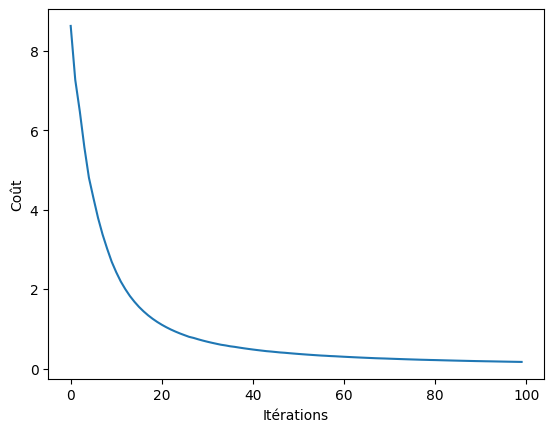

In [49]:
# Affichage de la fonction coût globale du modèle au fil des itérations
plt.plot(model.couts)
plt.xlabel("Itérations")
plt.ylabel("Coût")
plt.show()

## II. Test du modèle et comparaison

Dans cette section, nous allons tester le modèle XGBOOST depuis la [bibliothèque officielle](https://xgboost.readthedocs.io/en/stable/) sur un dataset de prédiction des maladies cardiaques trouvé sur Kaggle [içi](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease). Ensuite nous allons découvrir deux autres modèles (LightGBM et CatBoost) qui sont aussi des modèles qui se basent sur le concept de boosting et on les comparera avec le modèle XGBOOST.

### II.1 Test du modèle XGBOOST

In [50]:
# Importation des données

data = pd.read_csv("data/heart.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [51]:
# On remarque que les classes sont très deséquilibrées

values_count = data['HeartDisease'].value_counts()
values_count

HeartDisease
No     292422
Yes     27373
Name: count, dtype: int64

In [52]:
""" On réduit donc l'échantillon qu'on travaillera dessus en appliquant un under-sampling, juste pour
qu'on puisse bien visualiser les performances des modèles sur un dataset simple et équilibré"""
n = values_count['Yes'] # Taille de la plus petite classe
msk = data['HeartDisease'] == 'No'
data = pd.concat((data[msk].sample(n=n), data[~msk]), ignore_index=True) # Choisir aléatoirement un nombre n d'individus de la plus grande classe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54746 entries, 0 to 54745
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      54746 non-null  object 
 1   BMI               54746 non-null  float64
 2   Smoking           54746 non-null  object 
 3   AlcoholDrinking   54746 non-null  object 
 4   Stroke            54746 non-null  object 
 5   PhysicalHealth    54746 non-null  float64
 6   MentalHealth      54746 non-null  float64
 7   DiffWalking       54746 non-null  object 
 8   Sex               54746 non-null  object 
 9   AgeCategory       54746 non-null  object 
 10  Race              54746 non-null  object 
 11  Diabetic          54746 non-null  object 
 12  PhysicalActivity  54746 non-null  object 
 13  GenHealth         54746 non-null  object 
 14  SleepTime         54746 non-null  float64
 15  Asthma            54746 non-null  object 
 16  KidneyDisease     54746 non-null  object

In [53]:
# Diviser les données en X (caractéristiques explicatives) et Y (sortie)
# Il faut aussi remplacer les "Yes" et "No" par des valeurs booléennes

X = data.drop(columns=['HeartDisease'])
Y = data['HeartDisease']
X.replace({'Yes': True, 'No': False}, inplace=True)
X['Diabetic'].replace({False: 'No', True: 'Yes', 'No, borderline diabetes': 'No_borderline_diabetes', 'Yes (during pregnancy)': 'Yes_pregnancy'},
                      inplace=True)
Y.replace({'Yes': 1, 'No': 0}, inplace=True)

X.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,19.47,True,False,False,0.0,0.0,False,Female,18-24,White,No,False,Very good,8.0,False,False,False
1,36.49,True,True,False,2.0,0.0,False,Male,25-29,White,No,True,Excellent,5.0,False,False,True
2,33.67,True,False,False,0.0,30.0,False,Male,50-54,White,No,True,Very good,7.0,False,False,False
3,25.61,True,False,False,0.0,0.0,False,Female,65-69,Black,No,True,Good,8.0,False,False,False
4,22.31,False,False,False,30.0,0.0,True,Female,80 or older,White,No,False,Fair,8.0,False,False,False


In [54]:
# Diviser le dataset en dataset d'entrainement et dataset de test

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

# Appliquer un one hot encoding sur les variables qualitatives
X_train_one_hot = pd.get_dummies(X_train)
X_test_one_hot = pd.get_dummies(X_test)
X_train_one_hot.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity,SleepTime,Asthma,...,Race_White,Diabetic_No,Diabetic_No_borderline_diabetes,Diabetic_Yes,Diabetic_Yes_pregnancy,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
8623,28.62,False,False,False,0.0,20.0,False,False,7.0,False,...,False,True,False,False,False,False,False,True,False,False
10605,32.08,False,False,False,4.0,15.0,False,False,6.0,False,...,True,False,False,True,False,False,True,False,False,False
23612,23.67,False,False,False,1.0,5.0,False,True,8.0,False,...,True,True,False,False,False,True,False,False,False,False
1370,25.02,True,False,False,0.0,0.0,True,False,18.0,False,...,True,False,False,True,False,False,True,False,False,False
381,33.67,True,False,False,15.0,0.0,False,True,8.0,False,...,False,True,False,False,False,False,False,True,False,False


In [55]:
# Installation de la bibliothèque xgboost
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report
import timeit

train_times = []
train_errors = []
test_times = []
test_errors = []
scores = []

eval_set = [(X_train_one_hot, Y_train), (X_test_one_hot, Y_test)]
eval_metric = 'logloss'
xgb_model = XGBClassifier(n_estimators=100, eval_metric=eval_metric)

# Entrainement du modèle XGBOOST
start_time = timeit.default_timer()
xgb_model.fit(X_train_one_hot, Y_train, eval_set=eval_set, verbose=False)
train_time = timeit.default_timer() - start_time
train_times.append(train_time)

# Prédiction sur le dataset de test
start_time = timeit.default_timer()
xgb_pred = xgb_model.predict(X_test_one_hot)
test_time = timeit.default_timer() - start_time
test_times.append(test_time)
score = f1_score(Y_test, xgb_pred)
scores.append(score)

# Sauvegarde des coûts
errors = xgb_model.evals_result()['validation_0'][eval_metric] # lors de l'entrainement
val_errors = xgb_model.evals_result()['validation_1'][eval_metric] # lors des tests
train_errors.append(errors)
test_errors.append(val_errors)

print(classification_report(Y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      2707
           1       0.74      0.80      0.77      2768

    accuracy                           0.75      5475
   macro avg       0.76      0.75      0.75      5475
weighted avg       0.76      0.75      0.75      5475



Le modèle XGBOOST a un F1 score assez élevé de 0.76 sur le dataset de test, ce qui reflète une bonne performance. Le modèle a pu bien classer les individus auyant une maladie cardiaque de ceux qui n'ont pas de maladies cardiaques. On peut confirmer celà grâce le matrice de confusion suivante: 

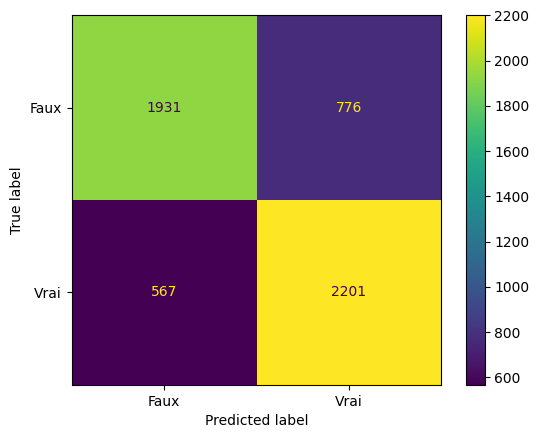

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(Y_test, xgb_pred)
cm_display = ConfusionMatrixDisplay(conf_mat, display_labels=["Faux", "Vrai"])
cm_display.plot()
plt.show()

### II.2 Comparaison avec LightGBM et Catboost

Dans cette section, on comparera les résultats obtenus avec le modèle XGBOOST avec ceux de LightGBM et Catboost. Mais d'abord il faudrait faire des brièves définitions pour ces modèles:
- **LightGBM** (Light Gradient Boosting Machine): est un framework de gradient-boosting open-source distribué, développé initialement par Microsoft (2016). Ce modèle construit aussi des arbres de régression pour sa prédiction en développant les meilleures feuilles (leaf-wise) ce qui est différent de la construction des arbres pour XGBOOST qui développe ses arbres par niveau (level-wise). Ce modèle est très populaire pour son optimization de l'utilisation de la mémoire et sa performance.

- **CatBoost**: est une bibliothèque opensource développée par Yandex (2017), elle fournit un framework de gradient-boosting spécialisée pour la gestion des caractéristiques catégoriques (données qualitatives) en utilisant des algorithmes dédiés et optimisés. Et c'est pour cet aspect que le modèle Catboost a gagné en popularité surtout au fait qu'il surpasse les autres modèles utilisant le boosting sur ce type de données. 

In [58]:
# Installation des bibliothèques
%pip install lightgbm
%pip install catboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

lgbm_model = LGBMClassifier(n_estimators=100, verbose=-1)
catboost_model = CatBoostClassifier(n_estimators=100 ,cat_features=['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory',
                                                  'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease',
                                                  'SkinCancer'], verbose=False)

# Entrainement du modèle LightGBM
eval_set = [(X_train_one_hot, Y_train), (X_test_one_hot, Y_test)]
eval_metric = 'binary_logloss'

start_time = timeit.default_timer()
lgbm_model.fit(X_train_one_hot, Y_train, eval_set=eval_set, eval_metric=eval_metric)
train_time = timeit.default_timer() - start_time
train_times.append(train_time)

errors = lgbm_model.evals_result_['training'][eval_metric] # Sauvegarde des coût d'entrainement
val_errors = lgbm_model.evals_result_['valid_1'][eval_metric] # Sauvegarde des coût de test
train_errors.append(errors)
test_errors.append(val_errors)

# Entrainement du modèle CatBoost
eval_original_set = [(X_test, Y_test)]
eval_metric = 'Logloss'

start_time = timeit.default_timer()
catboost_model.fit(X_train, Y_train, eval_set=eval_original_set)
train_time = timeit.default_timer() - start_time
train_times.append(train_time)

errors = catboost_model.evals_result_['learn'][eval_metric] # Sauvegarde des coût d'entrainement
val_errors = catboost_model.evals_result_['validation'][eval_metric] # Sauvegarde des coût de test
train_errors.append(errors)
test_errors.append(val_errors)

# Prédiction sur le dataset de test (LightGBM)
start_time = timeit.default_timer()
lgbm_pred = lgbm_model.predict(X_test_one_hot)
test_time = timeit.default_timer() - start_time
test_times.append(test_time)
score = f1_score(Y_test, lgbm_pred)
scores.append(score)

# Prédiction sur le dataset de test (Catboost)
start_time = timeit.default_timer()
catboost_pred = catboost_model.predict(X_test)
test_time = timeit.default_timer() - start_time
test_times.append(test_time)
score = f1_score(Y_test, catboost_pred)
scores.append(score)

In [60]:
# Résultats des tests
stat_results = pd.DataFrame({
    "Modèle": ["XGBOOST", "LightGBM", "CatBoost"],
    "Temps d'entrainment": train_times,
    "Temps de test": test_times,
    "F1 score": scores
})

stat_results

,Modèle,Temps d'entrainment,Temps de test,F1 score
0,XGBOOST,0.783727,0.030421,0.766232
1,LightGBM,0.368097,0.010490,0.775559
2,CatBoost,4.325189,0.197464,0.778776


Nous remarquons içi, que le modèle ayant le meilleur F1 score est le modèle CatBoost, il surpasse les autres modèles sur la qualité de ses prédictions. Par contre, c'est le plus lent en terme de temps d'entrainement et de test par rapport aux autres modèles. LightGBM est le plus rapide en terme de temps d'entrainement et de temps de test et il assure aussi un F1 score très proche de celui de Catboost. En conclusion, on pourrait dire que le modèle le plus performant pour ce problème et ces données en considérant tous les points serait LightGBM (mieux que XGBOOST) étant donné qu'il est le plus rapide en exécution et assez performant en terme de score et prédiction. 

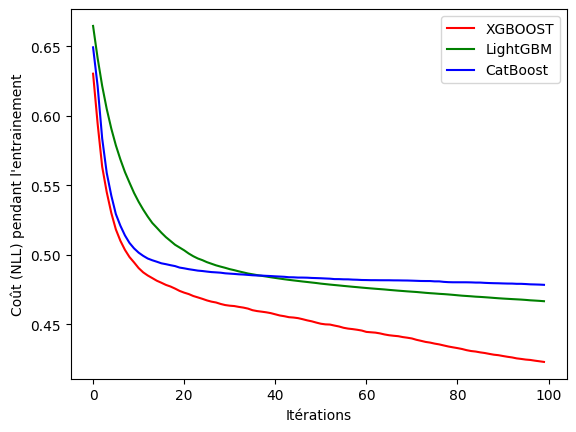

In [61]:
# Affichage de la diminition en coût des trois modèles pendant l'entrainement

plt.plot(train_errors[0], color='red', label="XGBOOST")
plt.plot(train_errors[1], color='green', label="LightGBM")
plt.plot(train_errors[2], color='blue', label="CatBoost")
plt.xlabel("Itérations")
plt.ylabel("Coût (NLL) pendant l'entrainement")
plt.legend()
plt.show()

Sur ce graph, on peut comparer la vitesse de convergence des différents algorithmes pendant l'entrainement, notons que tous les modèles ont été laissés avec leurs hyper-paramètres par défaut (sauf pour le nombre d'estimateurs qui est à 100 pour limiter le nombre d'itérations). On remarque bien que le modèle Catboost converge plus rapidement vers son optimum, suivi du modèle LightGBM ensuite celui de XGBOOST qui est le plus lent (plus lent en terme de nombre d'itérations nécessaire à arriver à son minimum de coût d'entrainement, pas en temps d'entrainement). Celà peut être dû au fait que Catboost et LightGBM dans leurs implementations ne chechent pas à trouver la solution optimale exacte mais plutôt une solution approchée ce qui fait converger ces algorithmes plus rapidement. Par contre l'implémentation par défaut d'XGBOOST cherche à trouver la solution optimale exacte et donc ça prend à l'algorithme plus d'itérations pour arriver au coût minimal.

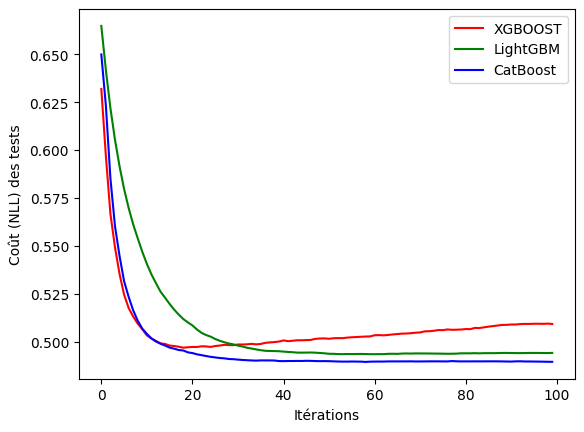

In [62]:
# Affichage du coût des trois modèles sur le dataset de validation (test) pour chaque itération

plt.plot(test_errors[0], color='red', label="XGBOOST")
plt.plot(test_errors[1], color='green', label="LightGBM")
plt.plot(test_errors[2], color='blue', label="CatBoost")
plt.xlabel("Itérations")
plt.ylabel("Coût (NLL) des tests")
plt.legend()
plt.show()

Sur ce graph, on peut visualiser et comparer la généralisation des modèles. On remarque içi que le modèle CatBoost arrive le plus rapidement au coût minimal et reste stable, suivi du modèle LightGBM qui se comporte de la même façon sauf qu'il est un peu moins rapide à arriver à son minimum. Ces modèles (CatBoost et LightGBM) ont une assez bonne performance sur les données de test (celà explique leurs F1 scores élévés précedemment) et évitent le sur-apprentissage (over-fitting). Par contre pour le modèle XGBOOST, on remarque que dès qu'il arrive au minimum, le coût augemente au fil des itérations, celà indique que le modèle XGBOOST est train de sur-apprendre (over-fitting). On en conclut que les modèles CatBoost et LightGBM évitent mieux l'over-fitting que le modèle XGBOOST.